In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd
import xarray

In [2]:
from matplotlib.colors import BoundaryNorm, ListedColormap
import colormaps as cmaps

def get_map_norm(cmap, levels, start=0, end=1):
    """
    Get a discrete colormap and normalization for plotting with matplotlib.
    Set start > 0 or end < 1 to eliminate portions of the color map from the low or high side, respectively. 
    """
    nlev = len(levels)
    cmap = plt.colormaps.get_cmap(cmap)
    colors = list(cmap(np.linspace(start, end, nlev)))
    cmap = ListedColormap(colors, '')
    norm = BoundaryNorm(levels, ncolors=nlev, clip=False)
    return cmap, norm

In [3]:
import cartopy.feature as cfeature
scale = '50m'
states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale,
    facecolor='none',
    edgecolor='k'
)

countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale=scale,
    facecolor='none',
    edgecolor='k'
)

In [4]:
# Plot this variable:
var = 'tob'

In [5]:
# Pre-calculated coefficients for logistic regression
coefs = xarray.open_dataset(f'/work/acr/mom6/nwa12/forecast_output_data/post_post_processed/logreg_coefs_forecast_{var}.nc')

# Quantile values from GLORYS
glorys_qs = (
    xarray.open_dataarray(f'/work/acr/mom6/nwa12/forecast_output_data/post_post_processed/logreg_quantiles_glorys_{var}.nc')
    .sel(quantile=[0.33, 0.67]) # just the tercile boundaries
    .load()
)

In [6]:
# Load a single forecast
forecast = xarray.open_dataset(f'/work/acr/mom6/nwa12/forecast_output_data/individual/{var}.nwa.full.ss_fcast.monthly.raw.r20250210.enss.i202502.nc')

In [7]:
# Grid information
static = xarray.open_dataset('/home/acr/git/nwa12/data/geography/ocean_static.nc')

The logistic regression only uses the ensemble mean.
For bottom variables, only data shallower than 500 m are plotted.

In [8]:
ensmean = forecast[var].mean('member').where(static.deptho < 500)

From GLORYS, there is a different quantile for each month. 
Here, select the monthly quantile values that match the months in the forecast.

In [9]:
qs = glorys_qs.sel(month=forecast['valid_time.month'])

Similarly, there is a different set of coefficients for each initialization (calendar) month. 
Here, choose the set for the month when this forecast was initialized. 

In [10]:
match_coefs = coefs.sel(month=int(forecast['init.month']))

In [11]:
def sigma(x):
    return 1 / (1 + np.exp(-x))
    
# Prob of not exceeding low tercile
plow = 1 - sigma(match_coefs['intercept'] + match_coefs['b1'] * ensmean + match_coefs['b2'] * qs.sel(quantile=0.33))

# Prob of exceeding high tercile
phigh =  sigma(match_coefs['intercept'] + match_coefs['b1'] * ensmean + match_coefs['b2'] * qs.sel(quantile=0.67))

# Prob of exceeding low tercile (1 - plow) but excluding the prob of exceeding high tercile
pmid = (1 - plow) - phigh

In [12]:
# Combine the probabilities together into one dataarray
cat = xarray.concat([plow, pmid, phigh], dim='category', coords='minimal', compat='override')
cat['category'] = np.arange(len(cat['category']))

# Find the highest probability and the category that probability is in
max_prob = cat.max('category')
max_cat = cat.idxmax('category', skipna=True)

Text(0.5, 1.0, 'Above normal')

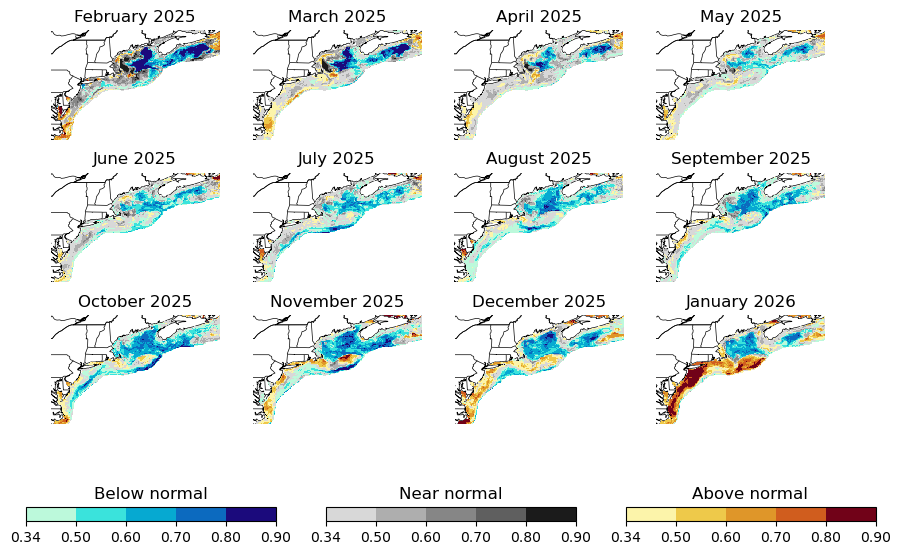

In [13]:
f = plt.figure(figsize=(10, 7))
nrows, ncols = 3, 4
grid = AxesGrid(f, 111, 
    nrows_ncols=(nrows, ncols),
    axes_class = (GeoAxes, dict(projection=ccrs.PlateCarree())),
    axes_pad=0.33,
    cbar_location='bottom',
    cbar_mode=None,
    cbar_pad=0.3,
    cbar_size='10%',
    label_mode='keep'
)
levels = [0.34, 0.5, 0.6, 0.7, 0.8, 0.9]

for ax in grid:
    ax.add_feature(states, zorder=1, linewidth=0.5, edgecolor='black')
    ax.add_feature(countries, zorder=1, linewidth=0.5, edgecolor='black')

for l, g in enumerate(grid):
    prob = max_prob.isel(lead=l)
    cat = max_cat.isel(lead=l)
    # Shortcut for repeated invocation of pcolormesh
    pcolor = partial(g.pcolormesh, static.geolon_c, static.geolat_c)
    # Plot where cold most likely
    cmap, norm = get_map_norm(cmaps.div1_blue_orange_r, levels=levels, start=0.55, end=0.95)
    p0 = pcolor(prob.where(cat==0), cmap=cmap, norm=norm)
    # Plot where normal most likely
    cmap, norm = get_map_norm(cmaps.cet_l_grey1_r, levels=levels, start=.1)
    p1 = pcolor(prob.where(cat==1), cmap=cmap, norm=norm)
    # Plot where warm most likely
    cmap, norm = get_map_norm(cmaps.div1_blue_orange, levels=levels, start=0.55, end=0.95)
    p2 = pcolor(prob.where(cat==2), cmap=cmap, norm=norm)
    # Set title
    valid = pd.Timestamp(prob['init'].values) + pd.DateOffset(months=l)
    g.set_title(f'{valid.month_name()} {valid.year}')

for ax in grid:
    ax.set_extent([-77, -60, 35, 46])
    for s in ax.spines.values():
        s.set_visible(False)

f.subplots_adjust(bottom=0.2)

cbax0 = f.add_axes([0.1, 0.12, 0.25, 0.02])
cbax1 = f.add_axes([0.4, 0.12, 0.25, 0.02])
cbax2 = f.add_axes([0.7, 0.12, 0.25, 0.02])

f.colorbar(p0, orientation='horizontal', cax=cbax0)
f.colorbar(p1, orientation='horizontal', cax=cbax1)
f.colorbar(p2, orientation='horizontal', cax=cbax2)

cbax0.set_title('Below normal')
cbax1.set_title('Near normal')
cbax2.set_title('Above normal')

Instead of the probability of exceeding a certain quantile value, it is also possible to calculate the probability of exceeding any single value. 

In [14]:
p18 = sigma(match_coefs['intercept'] + match_coefs['b1'] * ensmean + match_coefs['b2'] * 18.0)

/nbhome/Andrew.C.Ross/python/envs/medpy311_20250213/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


Text(0.5, 0.94, 'Probability of exceeding 18 °C')

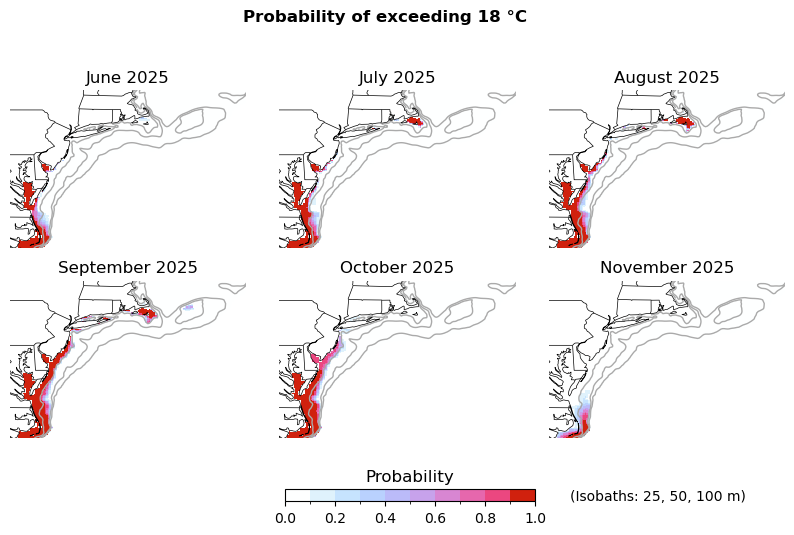

In [15]:
f = plt.figure(figsize=(10, 6))
nrows, ncols = 2, 3
grid = AxesGrid(f, 111, 
    nrows_ncols=(nrows, ncols),
    axes_class = (GeoAxes, dict(projection=ccrs.PlateCarree())),
    axes_pad=0.33,
    cbar_location='bottom',
    cbar_mode=None,
    cbar_pad=0.3,
    cbar_size='10%',
    label_mode='keep'
)

for ax in grid:
    ax.add_feature(states, zorder=999, linewidth=0.5, edgecolor='black')
    ax.add_feature(countries, zorder=999, linewidth=0.5, edgecolor='black')

for l, g in enumerate(grid, start=4):
    levels = np.arange(0, 1.01, .1)
    cmap, norm = get_map_norm(cmaps.cet_l_wcmr, levels=levels)
    p = g.pcolormesh(static.geolon_c, static.geolat_c, p18.sel(lead=l), cmap=cmap, norm=norm)
    valid = pd.Timestamp(prob['init'].values) + pd.DateOffset(months=l)
    g.set_title(f'{valid.month_name()} {valid.year}')

for ax in grid:
    ax.set_extent([-77, -65, 35, 43])
    for s in ax.spines.values():
        s.set_visible(False)
    ct = ax.contour(static.geolon, static.geolat, static.deptho, levels=[25, 50, 100], linewidths=1, colors='#aaaaaa')

f.subplots_adjust(bottom=0.15)

cbax = f.add_axes([0.4, 0.12, 0.25, 0.02])
f.colorbar(p, orientation='horizontal', cax=cbax)
cbax.set_title('Probability')
plt.text(1.0, 0.1, '        (Isobaths: 25, 50, 100 m)')
f.suptitle('Probability of exceeding 18 °C', fontweight='bold', y=0.94)